In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation


C:\Users\Maln\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.7) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
sales = pd.read_csv('../data/calgary_resales/total_sales.csv',index_col=0)
prices = pd.read_csv('../data/calgary_resales/total_avg_price.csv',index_col=0)
listings = pd.read_csv('../data/calgary_resales/total_active_listings.csv',index_col=0)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
sales_data = scaler.fit_transform(sales.values)

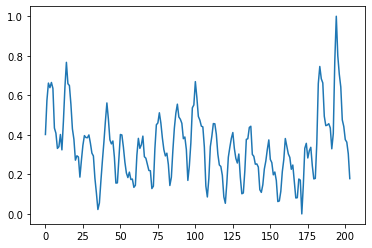

In [6]:
plt.plot(sales_data)


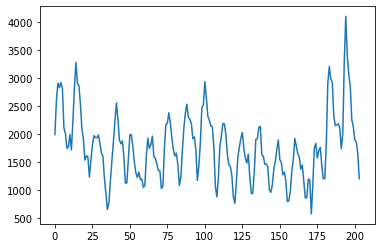

In [7]:
plt.plot(sales.values)

In [8]:
train_size = int(len(sales_data) * 0.75)
test_size = len(sales_data) - train_size
train, test = sales_data[0:train_size,:], sales_data[train_size:len(sales_data),:]
print(len(train), len(test))

153 51


In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [10]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
trainX.shape

(151, 1)

In [12]:
model = Sequential()
model.add(LSTM(100, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
151/151 - 1s - loss: 0.0327 - 1s/epoch - 9ms/step
Epoch 2/100
151/151 - 0s - loss: 0.0112 - 117ms/epoch - 775us/step
Epoch 3/100
151/151 - 0s - loss: 0.0092 - 113ms/epoch - 745us/step
Epoch 4/100
151/151 - 0s - loss: 0.0075 - 114ms/epoch - 755us/step
Epoch 5/100
151/151 - 0s - loss: 0.0067 - 118ms/epoch - 784us/step
Epoch 6/100
151/151 - 0s - loss: 0.0066 - 116ms/epoch - 768us/step
Epoch 7/100
151/151 - 0s - loss: 0.0065 - 116ms/epoch - 768us/step
Epoch 8/100
151/151 - 0s - loss: 0.0062 - 119ms/epoch - 785us/step
Epoch 9/100
151/151 - 0s - loss: 0.0064 - 119ms/epoch - 788us/step
Epoch 10/100
151/151 - 0s - loss: 0.0063 - 114ms/epoch - 752us/step
Epoch 11/100
151/151 - 0s - loss: 0.0063 - 116ms/epoch - 768us/step
Epoch 12/100
151/151 - 0s - loss: 0.0066 - 116ms/epoch - 769us/step
Epoch 13/100
151/151 - 0s - loss: 0.0066 - 113ms/epoch - 748us/step
Epoch 14/100
151/151 - 0s - loss: 0.0065 - 115ms/epoch - 763us/step
Epoch 15/100
151/151 - 0s - loss: 0.0066 - 131ms/epoch - 864us

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 2ms/step
Train Score: 276.23 RMSE
Test Score: 390.09 RMSE


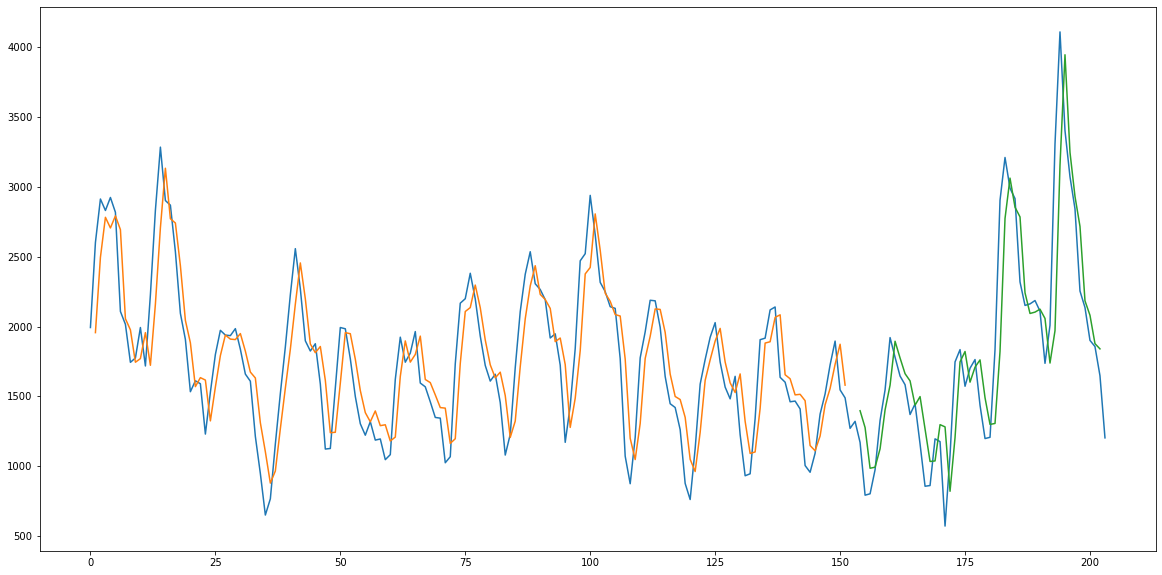

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(sales_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(sales_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(sales_data)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(sales_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.show()

In [16]:
tot_vol =pd.read_csv('../data/calgary_resales/total_volume.csv',index_col=0)
tot_vol.index = pd.to_datetime(tot_vol.index)

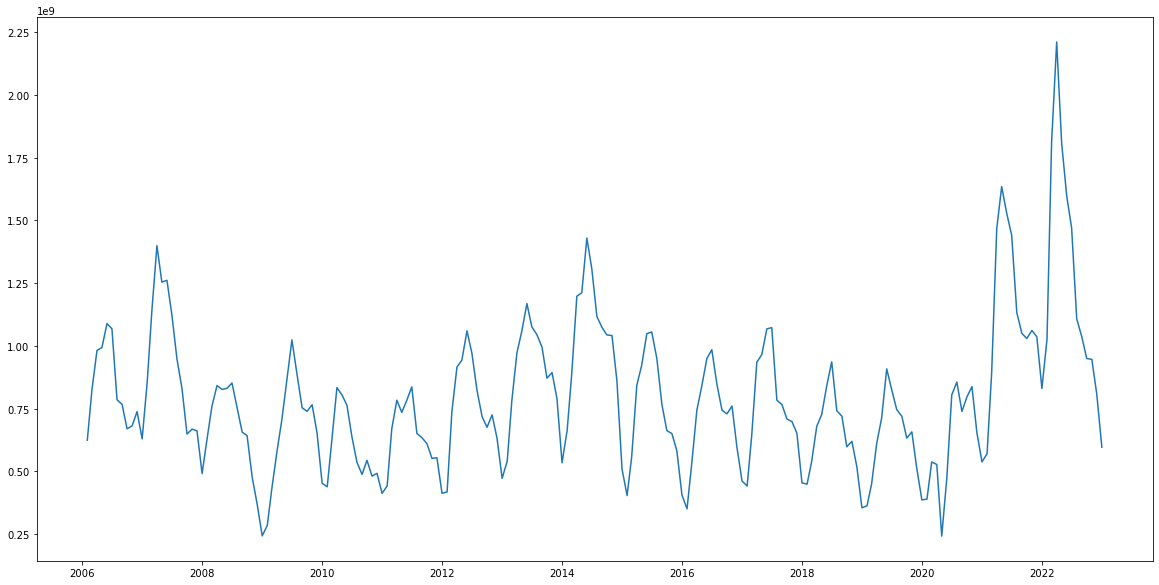

In [17]:
plt.figure(figsize=(20,10))
plt.plot(tot_vol)

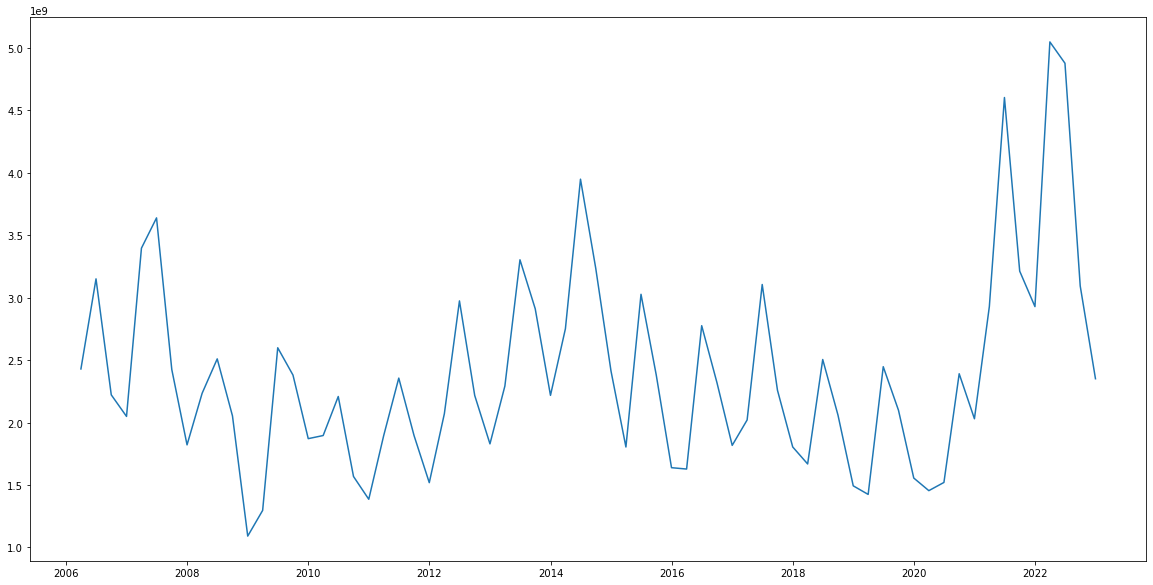

In [18]:
plt.figure(figsize=(20,10))

plt.plot(tot_vol.resample('Q').sum())

In [19]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.seasonal import STL
plt.rc("figure", figsize=(16, 10))

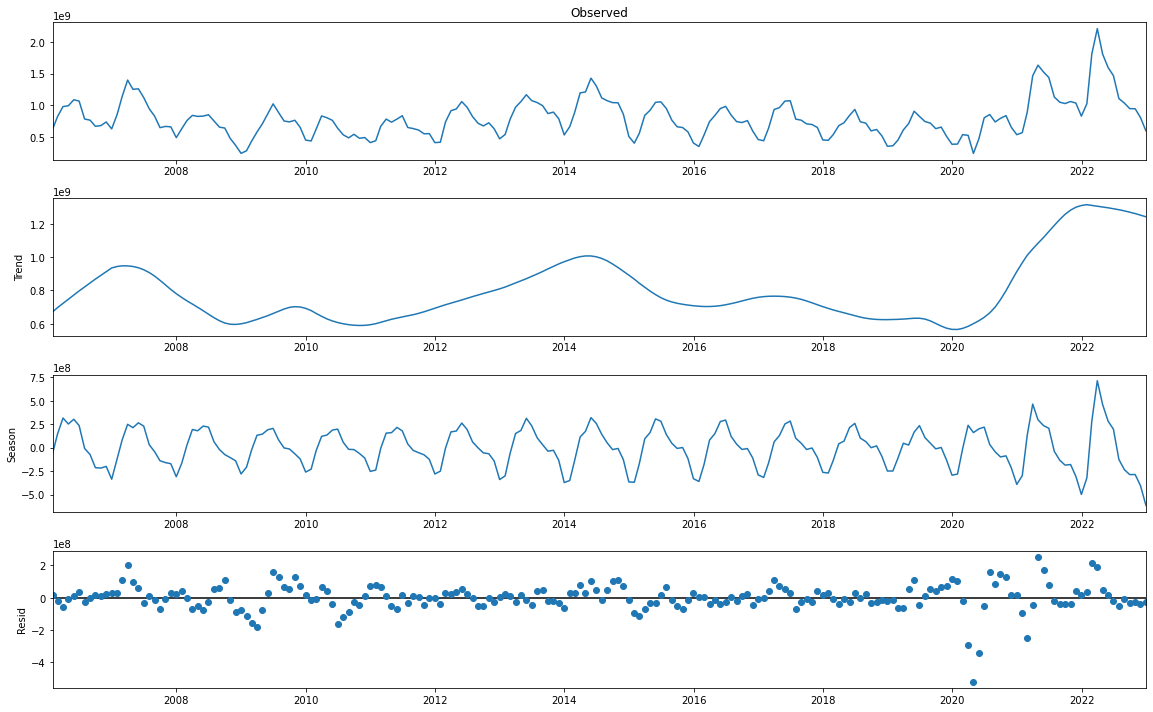

In [20]:
stl = STL(tot_vol, period = 12 )
res=stl.fit()
fig=res.plot()

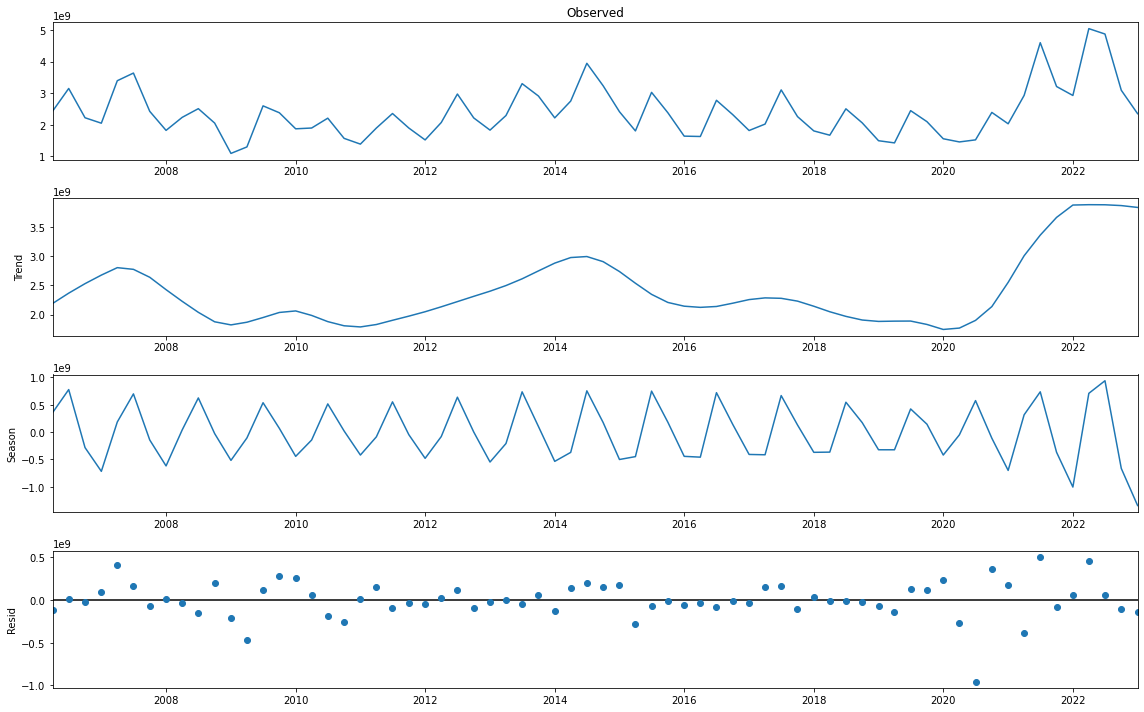

In [21]:
stl = STL(tot_vol.resample('Q').sum(), period = 4 )
res=stl.fit()
fig=res.plot()

In [37]:
nat_var = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='national',engine='openpyxl',index_col=0)
prov_var=pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='provincial',engine='openpyxl',index_col=0)
covid = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='covid_dummy',engine='openpyxl',index_col=0)
wti = pd.read_excel('../data/hmo_2023_variables.xlsx',sheet_name='wti',engine='openpyxl',index_col=0)


nat_var.index = nat_var.index.str.replace(' ','')
nat_var.index = nat_var.index.rename('Date')
nat_var.index = pd.PeriodIndex(nat_var.index,freq='Q').to_timestamp()

prov_var.index = prov_var.index.rename('Date')
prov_var.index = pd.PeriodIndex(prov_var.index,freq='Q').to_timestamp()


covid.index = covid.index.str.replace(' ','')
covid.index = covid.index.rename('Date')
covid.index = pd.PeriodIndex(covid.index,freq='Q').to_timestamp()

wti.index=wti.index.str.replace(' ','')
wti.index = wti.index.rename('Date')
wti.index = pd.PeriodIndex(wti.index,freq='Q').to_timestamp()

In [39]:
prov_var = prov_var.join(nat_var)
prov_var = prov_var.join(covid)
prov_var = prov_var.join(wti)

In [42]:
prov_var['1988':'2025']

,gdp_AB_2023,gdp_AB_2023_alt,unemp_AB_2023,unemp_AB_2023_alt,emp_AB_2023,emp_AB_2023_alt,cpi_AB_2023,cpi_AB_2023_alt,cpiyoy_AB_2023,cpiyoy_AB_2023_alt,policy_rate_base,policy_rate_alt,"Interest rate, 10-Year Benchmark Bond Yield",5_year_mortgage_base,5_year_mortgage_alt,COVID-19,Long COVID,WTI_base,WTI_lower,WTI_upper
Date,,,,,,,,,,,,,,,,,,,,
1988-01-01,143214.392000,143214.392000,8.266667,8.266667,1.215783e+03,1.215783e+03,67.536693,67.536693,0.040768,0.040768,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1988-04-01,145540.498000,145540.498000,7.866667,7.866667,1.220227e+03,1.220227e+03,68.005108,68.005108,0.031137,0.031137,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1988-07-01,144768.108000,144768.108000,7.900000,7.900000,1.223683e+03,1.223683e+03,68.145014,68.145014,0.019949,0.019949,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1988-10-01,143141.003000,143141.003000,7.900000,7.900000,1.231610e+03,1.231610e+03,68.519212,68.519212,0.017447,0.017447,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1989-01-01,146741.200000,146741.200000,7.466667,7.466667,1.243675e+03,1.243675e+03,69.220147,69.220147,0.024927,0.024927,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,90172.855574,88137.194085,8.990127,9.865552,2.392211e+06,2.369151e+06,170.388266,173.137233,0.021311,0.029259,3.080829,3.021285,3.327092,5.491311,5.514413,0.0,0.0,87.843871,75.479233,100.582117
2025-01-01,91372.531622,89355.725987,8.840621,9.688889,2.413583e+06,2.391186e+06,171.384360,174.377174,0.022049,0.029116,2.684537,2.625128,3.361462,5.448102,5.466124,0.0,0.0,89.249621,76.249724,102.445402
2025-04-01,92421.892096,90437.101561,8.608342,9.410141,2.432279e+06,2.410960e+06,172.391499,175.613743,0.022873,0.028990,2.499716,2.500545,3.378891,5.404907,5.477405,0.0,0.0,89.849685,75.836952,103.640708


In [ ]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log_diff']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)